In [1]:
## IMPORT DATA
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os 
import sklearn
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sys


import gzip
import os
import copy
import random


from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from matplotlib.pyplot import figure

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostRegressor

In [3]:
df=pd.read_csv('subscription.csv')

In [5]:
print(df.head())
print(df.columns)


   user_id subscription_signup_date  subscription_monthly_cost  country  \
0     1459            January, 2015                         29    Spain   
1    12474            January, 2015                         49   France   
2    12294            January, 2015                         49  Germany   
3     3878            January, 2015                         49    China   
4     9567            January, 2015                         49       UK   

  source  billing_cycles  is_active  
0    ads               4          0  
1    ads               5          0  
2    ads               2          0  
3    ads               1          0  
4    ads               5          0  
Index(['user_id', 'subscription_signup_date', 'subscription_monthly_cost',
       'country', 'source', 'billing_cycles', 'is_active'],
      dtype='object')


A model that predicts monthly retention rate for the different subscription price points


Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?


How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [7]:
df.groupby('subscription_monthly_cost').apply(lambda df: df.billing_cycles.value_counts()).unstack()
#df.groupby('user_id')['Item_id'].agg(['sum','count']).sort_values('count',ascending=False)

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,57441,21818,12037,7787,5505,4136,3111,34527
49,185145,53296,21690,11288,6727,4405,3173,14673
99,44788,4724,1471,678,399,226,156,799


In [10]:
# retention rate
df=df.drop(labels='subscription_signup_date',axis=1)

In [11]:
df.head()

,user_id,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,29,Spain,ads,4,0
1,12474,49,France,ads,5,0
2,12294,49,Germany,ads,2,0
3,3878,49,China,ads,1,0
4,9567,49,UK,ads,5,0


In [12]:
len(df)

500000

### retention rate


In [19]:
def retention_rate(df):
    total_num = len(df)
    rate = []
    for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        rate.append(len(df[df['billing_cycles'] >= i]) / total_num)
        
    return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])

In [20]:
retention_rate(df)

1    1.000000
2    0.425252
3    0.265576
4    0.195180
5    0.155674
6    0.130412
7    0.112878
8    0.099998
dtype: float64

In [21]:
grouped = df.groupby('subscription_monthly_cost').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,1.0,0.607542,0.458473,0.376232,0.323028,0.285416,0.257157,0.235901
49,1.0,0.383666,0.206247,0.134043,0.096466,0.074072,0.059408,0.048845
99,1.0,0.158769,0.070040,0.042411,0.029676,0.022182,0.017937,0.015007


Text(0, 0.5, 'Retention Rate')

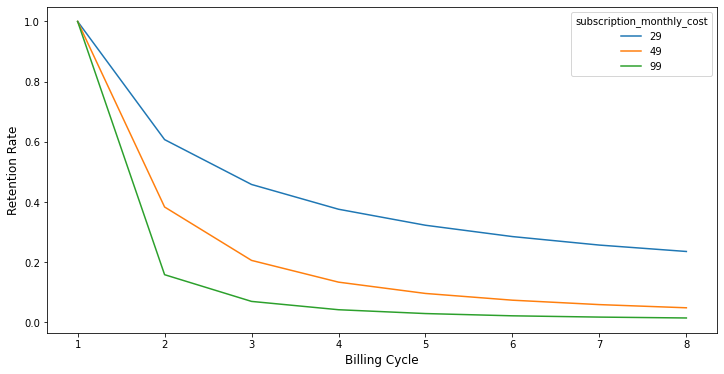

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

grouped.T.plot(kind='line', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)


### Now, let's add some non-linear component. For features, we add $x$, $x^2$, and $log(x)$ as the feature. For the target, we fit $log(rate)$ instead.


fit Linear Regression model
from above plot, we can draw following conclusions:

for each 'monthly_cost', there are only 8 samples.
complex model will overfit on samll dataset, so I decide to use a simple regression model - Linear Regression
the remaining #subscribers by the end of each billing cycles has a nonlinear relationship with #billing_cycles
so I need to include some nonlinear transformation of 'billing_cycles'
by no means, the target, #subscribers should be non-negative
so I cannot fit on original target, i.e., '#subscribers at the end of each billing cycle', but on log(#subscribers).
then after obtaining the fitted value, we transform back to '#subscribers' by exp(), which can guarantee the result is always positive

In [26]:

# Let's create features
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
x2 = x ** 2
logx = np.log(x)
rate_29 = grouped.loc[29].values
rate_49 = grouped.loc[49].values
rate_99 = grouped.loc[99].values

features = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx, 'y_29': rate_29, 'y_49': rate_49, 'y_99': rate_99}, 
                        columns=['x', 'x2', 'logx', 'y_29', 'y_49', 'y_99'])
features

,x,x2,logx,y_29,y_49,y_99
0,1,1,0.000000,1.000000,1.000000,1.000000
1,2,4,0.693147,0.607542,0.383666,0.158769
2,3,9,1.098612,0.458473,0.206247,0.070040
3,4,16,1.386294,0.376232,0.134043,0.042411
4,5,25,1.609438,0.323028,0.096466,0.029676
5,6,36,1.791759,0.285416,0.074072,0.022182
6,7,49,1.945910,0.257157,0.059408,0.017937
7,8,64,2.079442,0.235901,0.048845,0.015007


In [31]:
grouped.loc[29].values

array([1.        , 0.60754157, 0.45847283, 0.37623154, 0.32302784,
       0.28541561, 0.25715691, 0.2359014 ])

In [33]:
from sklearn.linear_model import LinearRegression


In [48]:
features.dtypes

x         int64
x2        int64
logx    float64
y_29    float64
y_49    float64
y_99    float64
dtype: object

In [54]:
features=np.array(features)


In [57]:
x=features[:,0:3]
x

array([[ 1.        ,  1.        ,  0.        ],
       [ 2.        ,  4.        ,  0.69314718],
       [ 3.        ,  9.        ,  1.09861229],
       [ 4.        , 16.        ,  1.38629436],
       [ 5.        , 25.        ,  1.60943791],
       [ 6.        , 36.        ,  1.79175947],
       [ 7.        , 49.        ,  1.94591015],
       [ 8.        , 64.        ,  2.07944154]])

In [63]:
# Fit linear regression model
model_29 = LinearRegression()
model_49 = LinearRegression()
model_99 = LinearRegression()

x=features[:, 0:3]
y_29=features[:,[3]]
y_49=features[:,[4]]
y_99=features[:,[5]]


In [64]:
y_29


array([[1.        ],
       [0.60754157],
       [0.45847283],
       [0.37623154],
       [0.32302784],
       [0.28541561],
       [0.25715691],
       [0.2359014 ]])

In [65]:
model_29 = model_29.fit(x, np.log(y_29))
model_49 = model_49.fit(x, np.log(y_49))
model_99 = model_99.fit(x, np.log(y_99))

In [66]:
model_29.

AttributeError: 'LinearRegression' object has no attribute 'summary'